# Small CNN Experminets

We'll build some small CNNs to train on CIFAKE and try tuning their hyperparameters

## Imports

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.optimizers import Adam
from keras.regularizers import l2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


## Load the data

In [2]:
train_data = np.load('CIFAKE_Train.npz')
test_data = np.load('CIFAKE_Test.npz')


In [3]:
x_test = test_data['images']
y_test = test_data['labels']


In [4]:
x_train, x_val, y_train, y_val = train_test_split(train_data['images'], train_data['labels'], test_size=0.2, random_state=42)


## Building Models

We'll define a function to create a CNN based on the hyperparameters we specify 

In [5]:
def create_custom_model(num_conv_layers, num_dense_layers, num_neurons):
    model = Sequential()

    # Add convolutional layers
    for _ in range(num_conv_layers):
        model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
        model.add(MaxPooling2D((2, 2)))

    # Flatten the output
    model.add(Flatten())

    # Add dense layers
    for _ in range(num_dense_layers):
        model.add(Dense(num_neurons, activation='relu'))

    # Output layer
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model


## Hyperparameter Tuning

We're going to do a manual grid search, so we'll first define the grids

In [6]:
# Define hyperparameter variations
num_conv_layers_list = [1, 2]
num_dense_layers_list = [1, 2, 4]
num_neurons_list = [128, 256, 512]
epochs = 2
batch_size = 64
validation_split = 0.2

# Lists to store results
val_accuracies = []
test_accuracies = []
labels = []


Execute the grid search over the hyperparameters

In [7]:
# Iterate over hyperparameters
for num_conv_layers in num_conv_layers_list:
    for num_dense_layers in num_dense_layers_list:
        for num_neurons in num_neurons_list:
            # Create and compile the model
            model = create_custom_model(num_conv_layers, num_dense_layers, num_neurons)

            # Train the model on your data (replace with your data loading code)
            model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,validation_data=(x_val,y_val))

            # Evaluate the model on validation data
            val_loss, val_accuracy = model.evaluate(x_val,y_val)
            val_accuracies.append(val_accuracy)

            # Evaluate the model on test data
            test_loss, test_accuracy = model.evaluate(x_test,y_test)
            test_accuracies.append(test_accuracy)

            # Create a label for this combination of hyperparameters
            label = f"ConvLayers={num_conv_layers}, DenseLayers={num_dense_layers}, Neurons={num_neurons}"
            labels.append(label)


Epoch 1/2
1250/1250 [==============================] - 17s 5ms/step - loss: 0.9171 - accuracy: 0.8218 - val_loss: 0.3047 - val_accuracy: 0.8719
Epoch 2/2
625/625 [==============================] - 2s 3ms/step - loss: 0.3111 - accuracy: 0.8673
Epoch 1/2
1250/1250 [==============================] - 8s 5ms/step - loss: 1.7415 - accuracy: 0.8193 - val_loss: 0.3518 - val_accuracy: 0.8525
Epoch 2/2
625/625 [==============================] - 2s 3ms/step - loss: 0.2845 - accuracy: 0.8848
Epoch 1/2
1250/1250 [==============================] - 8s 5ms/step - loss: 2.7856 - accuracy: 0.8101 - val_loss: 0.3451 - val_accuracy: 0.8565
Epoch 2/2
625/625 [==============================] - 2s 3ms/step - loss: 0.3172 - accuracy: 0.8707
Epoch 1/2
1250/1250 [==============================] - 8s 5ms/step - loss: 0.8993 - accuracy: 0.8210 - val_loss: 0.3136 - val_accuracy: 0.8666
Epoch 2/2
625/625 [==============================] - 2s 3ms/step - loss: 0.3038 - accuracy: 0.8754
Epoch 1/2
1250/1250 [==========

## Plotting Results

We'll plot the accuracies over different hyperparameters

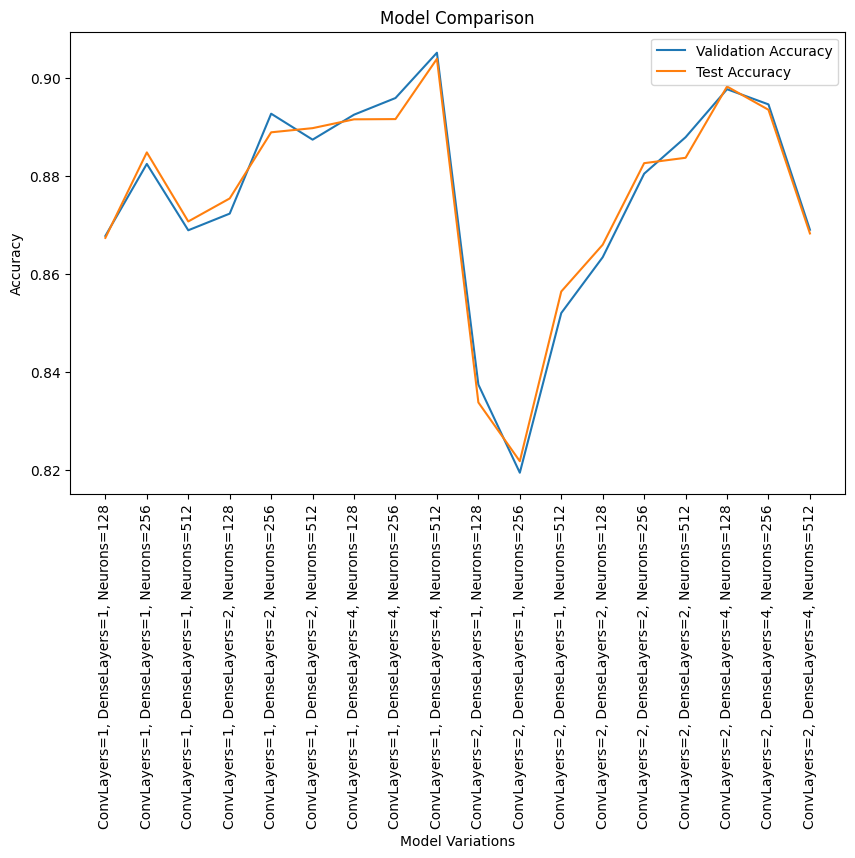

In [8]:
# Plot the results with labels
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(labels, val_accuracies, label='Validation Accuracy')
ax.plot(labels, test_accuracies, label='Test Accuracy')
ax.set_xlabel('Model Variations')
ax.set_ylabel('Accuracy')
ax.set_title('Model Comparison')
ax.legend()
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.show()


It is interesting that although there is definitely an accuracy difference, the range is only about 10% which suggests that CNN models are generally stable, and spending a bunch of time hyper-tuning them won't necessarily lead to much higher results

In [9]:
np.max(test_accuracies)


0.9039000272750854

## More Hyperparameters

Now that we did that grid search, we'll use the best model to tune more hyperparameters. We'll start by looking at L2 Regularization

In [10]:
# Define the range of L2 regularization strengths to experiment with
l2_strengths = [0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0]

# Initialize arrays to store accuracy results
val_accuracies = []
test_accuracies = []

for l2_strength in l2_strengths:
    # Create a model with the specified L2 regularization strength
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3), kernel_regularizer=l2(l2_strength)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation='relu', kernel_regularizer=l2(l2_strength)))
    model.add(Dense(512, activation='relu', kernel_regularizer=l2(l2_strength)))
    model.add(Dense(512, activation='relu', kernel_regularizer=l2(l2_strength)))
    model.add(Dense(512, activation='relu', kernel_regularizer=l2(l2_strength)))
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model on your data (replace with your data loading code)
    model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,validation_split=validation_split)

    # Evaluate the model on validation data
    val_loss, val_accuracy = model.evaluate(x_val,y_val)
    val_accuracies.append(val_accuracy)

    # Evaluate the model on test data
    test_loss, test_accuracy = model.evaluate(x_test,y_test)
    test_accuracies.append(test_accuracy)

    # Create a label for this combination of hyperparameters
    label = f"ConvLayers={num_conv_layers}, DenseLayers={num_dense_layers}, Neurons={num_neurons}"
    labels.append(label)


Epoch 1/2
1000/1000 [==============================] - 9s 7ms/step - loss: 2.3635 - accuracy: 0.8205 - val_loss: 1.2378 - val_accuracy: 0.8891
Epoch 2/2
625/625 [==============================] - 2s 3ms/step - loss: 0.9893 - accuracy: 0.8856
Epoch 1/2
1000/1000 [==============================] - 8s 7ms/step - loss: 7.3393 - accuracy: 0.8141 - val_loss: 3.2327 - val_accuracy: 0.8774
Epoch 2/2
625/625 [==============================] - 2s 4ms/step - loss: 1.4614 - accuracy: 0.8798
Epoch 1/2
1000/1000 [==============================] - 8s 6ms/step - loss: 33.7054 - accuracy: 0.7738 - val_loss: 7.3916 - val_accuracy: 0.8108
Epoch 2/2
625/625 [==============================] - 2s 4ms/step - loss: 1.6253 - accuracy: 0.8252
Epoch 1/2
1000/1000 [==============================] - 8s 6ms/step - loss: 29.5542 - accuracy: 0.7480 - val_loss: 1.0127 - val_accuracy: 0.7749
Epoch 2/2
625/625 [==============================] - 2s 3ms/step - loss: 0.6869 - accuracy: 0.7862
Epoch 1/2
1000/1000 [=========

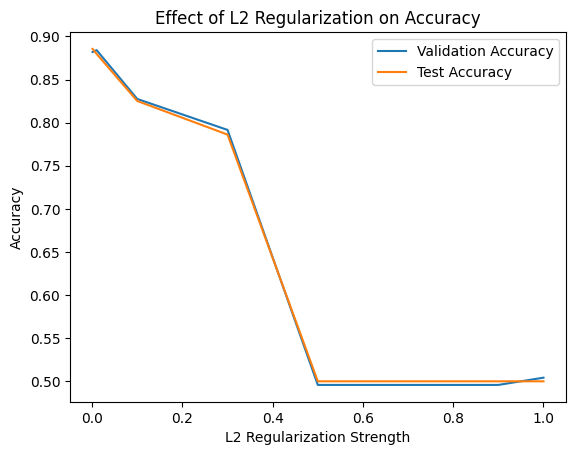

In [11]:
# Plot the results
plt.plot(l2_strengths, val_accuracies, label='Validation Accuracy')
plt.plot(l2_strengths, test_accuracies, label='Test Accuracy')
plt.xlabel('L2 Regularization Strength')
plt.ylabel('Accuracy')
plt.title('Effect of L2 Regularization on Accuracy')
plt.legend()
plt.show()


It doesn't seem like increasing the regularization strength helped. We'll look at dropout next

In [12]:
# Define the range of dropout rates to experiment with
dropout_rates = [0.1, 0.2, 0.3, 0.4, 0.5]

# Initialize arrays to store accuracy results
validation_accuracies = []
test_accuracies = []

for dropout_rate in dropout_rates:
    # Create a model with the specified dropout rate
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(dropout_rate))  # Add Dropout with the specified rate
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model (assuming you have already split your data into training, validation, and test sets)
    model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split)

    # Evaluate the model on the validation set
    validation_loss, validation_accuracy = model.evaluate(x_val, y_val)
    validation_accuracies.append(validation_accuracy)

    # Evaluate the model on the test set
    test_loss, test_accuracy = model.evaluate(x_test, y_test)
    test_accuracies.append(test_accuracy)


Epoch 1/2
1000/1000 [==============================] - 8s 6ms/step - loss: 0.8789 - accuracy: 0.8243 - val_loss: 0.3157 - val_accuracy: 0.8671
Epoch 2/2
625/625 [==============================] - 2s 4ms/step - loss: 0.2934 - accuracy: 0.8855
Epoch 1/2
1000/1000 [==============================] - 7s 6ms/step - loss: 0.7789 - accuracy: 0.8240 - val_loss: 0.3202 - val_accuracy: 0.8723
Epoch 2/2
625/625 [==============================] - 2s 3ms/step - loss: 0.2483 - accuracy: 0.8944
Epoch 1/2
1000/1000 [==============================] - 8s 6ms/step - loss: 1.0751 - accuracy: 0.8287 - val_loss: 0.2744 - val_accuracy: 0.8895
Epoch 2/2
625/625 [==============================] - 2s 3ms/step - loss: 0.2944 - accuracy: 0.8856
Epoch 1/2
1000/1000 [==============================] - 8s 7ms/step - loss: 1.0473 - accuracy: 0.8110 - val_loss: 0.3294 - val_accuracy: 0.8606
Epoch 2/2
625/625 [==============================] - 2s 3ms/step - loss: 0.2576 - accuracy: 0.8923
Epoch 1/2
1000/1000 [===========

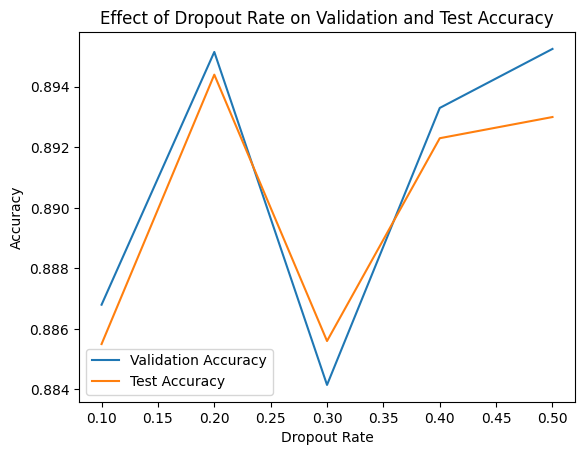

In [13]:
# Plot the results
plt.plot(dropout_rates, validation_accuracies, label='Validation Accuracy')
plt.plot(dropout_rates, test_accuracies, label='Test Accuracy')
plt.xlabel('Dropout Rate')
plt.ylabel('Accuracy')
plt.title('Effect of Dropout Rate on Validation and Test Accuracy')
plt.legend()
plt.show()


Dropout seems to not affect the accuracy very much, but there are values that increase the accuracy. Now we'll train our fully optimized model

In [14]:
model = Sequential()

# Add convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3), kernel_regularizer=l2(0.001)))
model.add(MaxPooling2D((2, 2)))

# Flatten the output
model.add(Flatten())

# Add dense layers
for _ in range(4):
    model.add(Dense(num_neurons, activation='relu', kernel_regularizer=l2(0.001)))

model.add(Dropout(0.2))

# Output layer
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [15]:
model.fit(x_train,y_train,epochs=10,batch_size=batch_size,validation_split=validation_split)


Epoch 1/10
1000/1000 [==============================] - 9s 6ms/step - loss: 2.5317 - accuracy: 0.8211 - val_loss: 1.3299 - val_accuracy: 0.8704
Epoch 2/10
1000/1000 [==============================] - 6s 6ms/step - loss: 1.1454 - accuracy: 0.8833 - val_loss: 0.9999 - val_accuracy: 0.8851
Epoch 3/10
1000/1000 [==============================] - 6s 6ms/step - loss: 0.8728 - accuracy: 0.8953 - val_loss: 0.8082 - val_accuracy: 0.8853
Epoch 4/10
1000/1000 [==============================] - 6s 6ms/step - loss: 0.6930 - accuracy: 0.9023 - val_loss: 0.6466 - val_accuracy: 0.9016
Epoch 5/10
1000/1000 [==============================] - 6s 6ms/step - loss: 0.5638 - accuracy: 0.9042 - val_loss: 0.6004 - val_accuracy: 0.8646
Epoch 6/10
1000/1000 [==============================] - 6s 6ms/step - loss: 0.4661 - accuracy: 0.9067 - val_loss: 0.4577 - val_accuracy: 0.8901
Epoch 7/10
1000/1000 [==============================] - 6s 6ms/step - loss: 0.3946 - accuracy: 0.9098 - val_loss: 0.4699 - val_accuracy:

In [16]:
model.evaluate(x_val, y_val)


625/625 [==============================] - 2s 3ms/step - loss: 0.3262 - accuracy: 0.8987


[0.32619285583496094, 0.8986999988555908]

In [17]:
model.evaluate(x_test,y_test)


625/625 [==============================] - 2s 3ms/step - loss: 0.3225 - accuracy: 0.8999


[0.3225374221801758, 0.8999000191688538]